In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from numpy import linalg as LA
from scipy.integrate import solve_ivp
import itertools
import jax.numpy as jnp
import pickle
import matplotlib.style as style
style.use('seaborn-colorblind')
%autosave 10

Autosaving every 10 seconds


# Low density limit

In [65]:
c = 0
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0)

x = [i for i in [0, 2, 4, 6, 8, 10]]
hopping_discrete = [p for p in itertools.product(x, repeat=5)]


def coefficient_matrix(t, y):
    m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                  for j in range(5)])-np.diag(h)
    return m@y


def cal_average_std(sol, hoppings=hopping_discrete, time_steps=10):
    fitness = [[np.sum(sol[i].y[:, t]) for i in range(len(hoppings))]
               for t in range(time_steps)]
    prob = [fitness[t]/np.sum(fitness[t]) for t in range(time_steps)]
    avehop = np.array([np.sum([prob[t][i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0) for t in range(time_steps)])
    variance = np.array([np.sum([prob[t][i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop[t]**2 for t in range(time_steps)])
    return avehop, np.sqrt(variance)

In [68]:
b = [0, 1, 2, 3, 5]
k = 1
sol = []
t_eval = np.linspace(0, 20, 100)
for i in range(len(hopping_discrete)):
    h = hopping_discrete[i]
#     test = []
    sol.append(solve_ivp(coefficient_matrix, [0, 20], [0.1 for _ in range(5)], t_eval=t_eval))
#     sol.append(np.concatenate(tuple(test[i].y for i in range(20)), -1))

In [69]:
ave,std = cal_average_std(sol,hoppings=hopping_discrete)


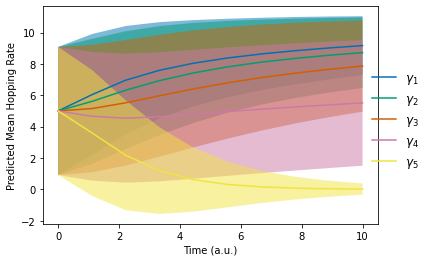

In [64]:
for i in range(5):
    plt.plot(t_eval,np.array(ave)[:,i],label="$\gamma_{}$".format(i+1))
    plt.fill_between(t_eval,np.array(ave)[:,i]-np.array(std)[:,i], np.array(ave)[:,i]+np.array(std)[:,i], alpha=0.5)

#     plt.plot(np.array(std03)[:,i], label='std {}'.format(i))
plt.ylabel('Predicted Mean Hopping Rate')   
plt.xlabel('Time (a.u.)')
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.95, 0.75),frameon=False,fontsize=12)
# p

# Largest eigenvalue: effective reward function

In [42]:
b=[0,1,2,3,4]
def max_eigen(hopping):
    """Explicitly write down the coefficient matrix for w=[0.2,0.2,0.2,0.2,0.2] and calculate the largest two eigenvalues"""
    A= np.array([[0.2*b[0]-0.8*hopping[0],0.2*(b[1]+hopping[1]),0.2*(b[2]+hopping[2]),0.2*(b[3]+hopping[3]),0.2*(b[4]+hopping[4])],
         [0.2*(b[0]+hopping[0]),0.2*b[1]-0.8*hopping[1],0.2*(b[2]+hopping[2]),0.2*(b[3]+hopping[3]),0.2*(b[4]+hopping[4])],
         [0.2*(b[0]+hopping[0]),0.2*(b[1]+hopping[1]),0.2*b[2]-0.8*hopping[2],0.2*(b[3]+hopping[3]),0.2*(b[4]+hopping[4])],
         [0.2*(b[0]+hopping[0]),0.2*(b[1]+hopping[1]),0.2*(b[2]+hopping[2]),0.2*b[3]-0.8*hopping[3],0.2*(b[4]+hopping[4])],
         [0.2*(b[0]+hopping[0]),0.2*(b[1]+hopping[1]),0.2*(b[2]+hopping[2]),0.2*(b[3]+hopping[3]),0.2*b[4]-0.8*hopping[4]]])
    return np.sort(LA.eig(A)[0])[-2:]

def max_eigen2(h):
    """Compactly generate coefficient matrix and calculate the largest two eigenvalues"""
    m=np.outer(w,np.array(b)+np.array(h))-np.diag(h)
    return np.sort(LA.eig(m)[0])[-2:]

def plot_largest2eigenvalues(sample_size=100000,random_birth_rate=False):
    """Plot the scatter plot of the largest 2 eigenvalues for randomly generated hopping rate with or without random birth rate"""
    eign=[]
    for i in range(sample_size):
        if random_birth_rate:
            global b
            b=np.random.rand(5)*10
        eign.append(max_eigen2(np.random.rand(5)*10))
    plt.scatter(np.array(eign)[:,0],np.array(eign)[:,1],s=2)
    plt.vlines(0,0,3)
    plt.hlines(0,-10,0)
    plt.xlabel("Second largest eigenvalue",fontsize=18)
    plt.ylabel("Largest eigenvalue",fontsize=18)
    plt.show()

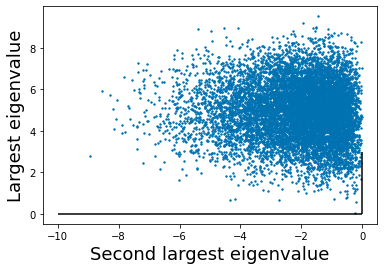

In [41]:
plot_largest2eigenvalues(10000,True)

# High density coupled system of differential equations

In [105]:
x = [i for i in [0,2,4,6,8,10]]
permurep=np.array([p for p in itertools.product(x, repeat=5)])
# permurep=[[10,10,10,10,0],[10,10,10,0,0]]
# permurep=[[10,10,10,10,0],[10,10,10,0,0],[10,10,10,9,0]]
c=0
p0=[np.exp(-c*i) for i in range(5)]
w=p0/np.sum(p0)
#     y=np.array([1,2,3,4,5,6,7,8,9,10])
b=[0,1,2,3,5]
# del(k)
def coupling(i,y):
    return (1-np.sum(y.reshape(-1,5)[:,i])/k)

def coupled_coef_matrix(t,y,hopping=np.array(permurep)): # move k to initial conditions
    couplings=[(1-np.sum(y.reshape(-1,5)[:,i])/k) for i in range(5)]
    coupling_sum=np.sum([couplings[i]*w[i] for i in range(5)])
    block=[]
    for i in range(len(hopping)):
        h=hopping[i]
        block.append(np.array([[w[j]*couplings[j]*(b[i]+h[i]) for i in range(5)] for j in range(5)])-np.diag([coupling_sum*h[j] for j in range(5)]))
    return block_diag(*block)@y

def h4(sol):
    return [np.sum([np.sum(sol[i*5:i*5+5,t])*permurep[i][3] for i in range(len(permurep))])/np.sum(sol[:,t]) for t in range(sol.shape[-1])]

def solve_coupled(n=101):
    sol=[solve_ivp(coupled_coef_matrix2, [0,0],np.array([0.1]*(5*len(permurep))))]
    t_eval=np.linspace(0,0.3,10)  
    
    for i in range(1,n):
        sol.append(solve_ivp(coupled_coef_matrix2, [0,0.3], sol[i-1].y[:,-1]*np.sum(sol[0].y[:,-1])*(1/np.sum(sol[i-1].y[:,-1])),t_eval=t_eval))
    sol=np.concatenate(tuple(sol[i].y for i in range(n)),-1)
    return sol

25083.870967741936
6373.770491803279
1593.4426229508197
895.852534562212


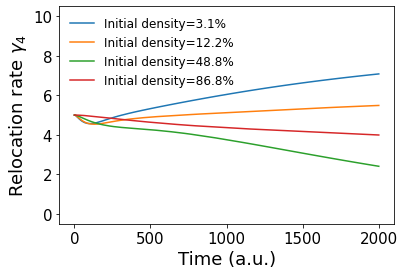

In [173]:
for k in [0.1*len(permurep)/0.031,0.1*len(permurep)/0.122,0.1*len(permurep)/0.488,0.1*len(permurep)/0.868]:#,0.1*len(permurep)/0.868,0.1*len(permurep)/0.945]:
    ave=solve_coupled(201)
    print(k)
    plt.plot(ave,label='Initial density={:.1f}%'.format(0.1*len(permurep)/k*100))
    plt.xlabel('Time (a.u.)', fontsize=18)
    plt.ylabel('Relocation rate $\gamma_4$', fontsize=18)
    plt.ylim(-0.5,10.5)
#     plt.gca().set_xticks([0,5000,10000,15000,20000])
    plt.gca().tick_params(axis='x',labelsize=15)
    plt.gca().tick_params(axis='y',labelsize=15)
#     plt.text(800,8,'K={}'.format(k),fontsize=18)
plt.legend(frameon=False,fontsize=12)
plt.savefig('./Paper_1_Figures/density_mean_field_full.pdf')

In [106]:
full_sol=[]
for k in [0.1*len(permurep)/0.031,0.1*len(permurep)/0.122,0.1*len(permurep)/0.488,0.1*len(permurep)/0.868,0.1*len(permurep)/0.945]:#,0.1*len(permurep)/0.868,0.1*len(permurep)/0.945]:
    full_sol.append(solve_coupled(2001))
    print(k)
#     plt.plot(ave,label='Initial density={:.1f}%'.format(0.1*len(permurep)/k*100))
#     plt.xlabel('Time (a.u.)', fontsize=18)
#     plt.ylabel('Relocation rate $\gamma_4$', fontsize=18)
#     plt.ylim(-0.5,10.5)
# #     plt.gca().set_xticks([0,5000,10000,15000,20000])
#     plt.gca().tick_params(axis='x',labelsize=15)
#     plt.gca().tick_params(axis='y',labelsize=15)
#     plt.text(800,8,'K={}'.format(k),fontsize=18)
# plt.legend(frameon=False,fontsize=12)
with open('./evolve_data/full_sol_high_density', "wb") as fp: 
    pickle.dump(full_sol, fp)

25083.870967741936
6373.770491803279
1593.4426229508197
895.852534562212
822.8571428571429


NameError: name 'pickle' is not defined

In [136]:
np.array(ave).shape
with open('./evolve_data/full_sol_high_density_avehop4_10', "wb") as fp: 
    pickle.dump(ave, fp)

In [124]:
full_sol_10=[full_sol[i][:,::10].copy() for i in range(5)]
full_sol_10[0].shape
with open('./evolve_data/full_sol_high_density_10', "wb") as fp: 
    pickle.dump(full_sol_10, fp)

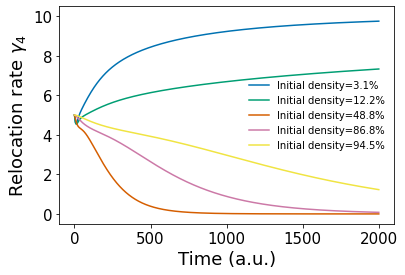

In [151]:
full_sol[0].shape
def h4(sol):
    return [np.sum([np.sum(sol[i*5:i*5+5,t])*permurep[i][3] for i in range(len(permurep))])/np.sum(sol[:,t]) for t in range(0,sol.shape[-1])]
density=[0.031,0.122,0.488,0.868,0.945]
# ave=[]
for i in range(5):
#     ave.append(h4(full_sol_10[i]))
    plt.plot(ave[i],label='Initial density={:.1f}%'.format(density[i]*100))
    plt.xlabel('Time (a.u.)', fontsize=18)
    plt.ylabel('Relocation rate $\gamma_4$', fontsize=18)
    plt.ylim(-0.5,10.5)
#     plt.gca().set_xticks([0,5000,10000,15000,20000])
    plt.gca().tick_params(axis='x',labelsize=15)
    plt.gca().tick_params(axis='y',labelsize=15)
#     plt.text(800,8,'K={}'.format(k),fontsize=18)
plt.legend(frameon=False,fontsize=10)
plt.savefig('./Paper_1_Figures/density_mean_field_full.pdf')

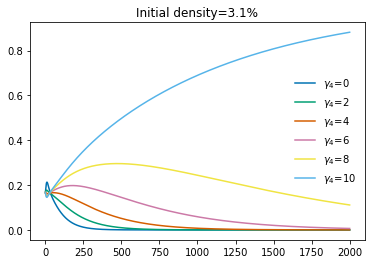

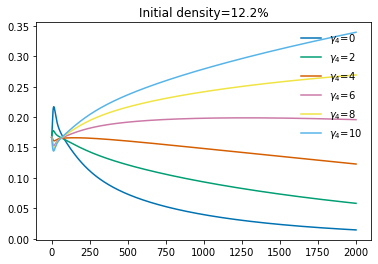

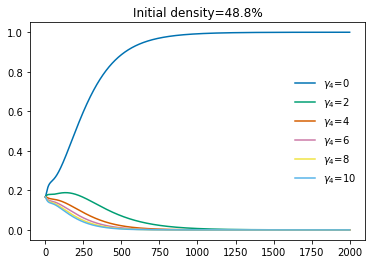

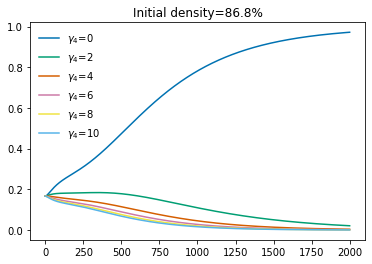

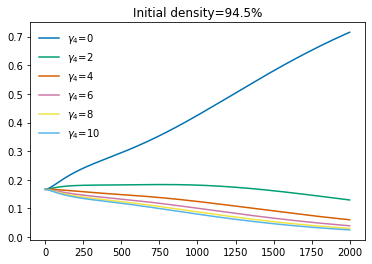

In [189]:
time_steps=2001
density=[0.031,0.122,0.488,0.868,0.945]
for density_no in range(5):
    prop=np.array([[np.sum([np.sum(full_sol_10[density_no][i*5:i*5+5,t]) for i in [i for i in range(len(permurep)) if permurep[i,-2]==j ]]) for t in range(time_steps)] for j in [0,2,4,6,8,10]])
    for i in range(6):
        plt.plot(prop[i,:]/np.sum(prop,axis=0),label="$\gamma_4$={}".format([0,2,4,6,8,10][i]))
    plt.legend(frameon=False,fontsize=10)
    plt.title('Initial density={:.1f}%'.format(density[density_no]*100))
    plt.show()

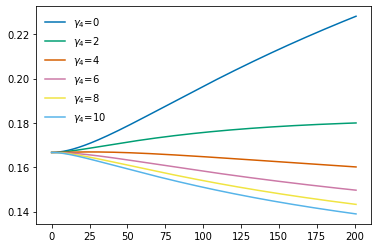

In [184]:
# plt.plot(prop.T)

for i in range(6):
    plt.plot(prop[i,:]/np.sum(prop,axis=0),label="$\gamma_4$={}".format([0,2,4,6,8,10][i]))
plt.legend(frameon=False,fontsize=10)

In [180]:
np.sum(prop,axis=0).shape

(202,)

# Neural ODE

In [34]:
from jax.experimental.ode import odeint
from jax.api import jit, grad
def odenet( inputs): # params is hopping
    start_and_end_times = jnp.array([0.0, 0.3])
    init_state, final_state = odeint(coupled_coef_matrix, inputs, start_and_end_times, atol=0.001, rtol=0.001)
    return final_state

In [35]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

In [36]:
# odenet_layer_sizes = [2, 20, 1]
k=len(permurep)
def odenet_loss(inputs):
    preds = batched_odenet(inputs)
    return jnp.sum((preds*jnp.sum(inputs)/jnp.sum(preds) - inputs)**2)

@jit
def odenet_update(inputs):
    grads = grad(odenet_loss)(inputs)
    return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(inputs, grads)]

# Initialize and train ODE-Net.
ini_inputs = np.random.rand(len(permurep)*5)

for i in range(1):
    odenet_params = odenet_update(ini_inputs)


ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (None, 0) for value tree PyTreeDef(tuple, [*]).

In [184]:
len(permurep)

7776

In [37]:
odenet(ini_inputs)

TypeError: reshape total size must be unchanged, got new_sizes (0, 5) for shape ().

In [21]:
np.sum(ini_inputs.reshape(-1,5)[:,1])

3928.984337825316

In [103]:
solve_ivp(coupled_coef_matrix2, [0,0.3], ini_inputs, atol=0.001, rtol=0.001)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.05911678, 0.1835563 , 0.3       ])
 t_events: None
        y: array([[ 0.99913834,  0.90821714,  0.8022514 ,  0.74878806],
       [ 0.55230712,  0.46093814,  0.35448858,  0.30101342],
       [ 0.79337481,  0.70221094,  0.59521678,  0.54150831],
       ...,
       [ 0.71144041,  0.79789113,  1.29404391,  2.03632713],
       [ 0.34211218,  0.03062686, -0.87578462, -2.00561874],
       [ 0.84512223,  1.09171997,  2.151021  ,  3.65040024]])

In [101]:
odeint(coupled_coef_matrix2,  ini_inputs,[0,0.000001], atol=0.001, rtol=0.001)

TypeError: reshape total size must be unchanged, got new_sizes (0, 5) for shape ().

In [95]:
coupled_coef_matrix(0,ini_inputs)

array([ 0.67008867,  0.66834214,  0.67066181, ..., -0.19711506,
        1.65659205, -0.81970354])

In [93]:
def coupled_coef_matrix2(t,y,hopping=np.array(permurep)):
    couplings=[(1-np.sum(y.reshape(-1,5)[:,i])/k) for i in range(5)]
    coupling_sum=np.sum([couplings[i]*w[i] for i in range(5)])
    block=[]
    for i in range(len(hopping)):
        h=hopping[i]
        block.append((np.array([[w[j]*couplings[j]*(b[i]+h[i]) for i in range(5)] for j in range(5)])-np.diag([coupling_sum*h[j] for j in range(5)]))@y[i*5:i*5+5])
    return np.array(block).reshape(-1)#[block[i]@y[i*5:i*5+5] for i in range(len(hopping))]

In [94]:
coupled_coef_matrix2(0,ini_inputs)

array([ 0.67008867,  0.66834214,  0.67066181, ..., -0.19711506,
        1.65659205, -0.81970354])